In [1]:
# Imports
from vosk import Model, KaldiRecognizer, SpkModel, SetLogLevel
import wave
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
SetLogLevel(-1)

In [2]:
# Init audio, model, speaker model
os.chdir("D:\\Projects\\Python\\NLP")
wf = wave.open("Audio/Clement_deb.wav")
frameSize = wf.getnframes()
frameRate = wf.getframerate()

model = Model("Model")
spk_model = SpkModel("ModelSpk/vosk-model-spk-0.4")
rateBuf = 4
nBufferFrame = frameRate // rateBuf

In [3]:
# Words recognition
wf.rewind()
rec = KaldiRecognizer(model, frameRate)
while True:
    data = wf.readframes(frameRate // rateBuf)
    if len(data) == 0:
        break
    rec.AcceptWaveform(data)
finalResults = json.loads(rec.FinalResult()) 
wordResult = finalResults['result'] # Word results here

In [13]:
# Functions to obtain data frames
def fonc1(startTime, stopTime):
    nFrame = int(np.ceil((stopTime - startTime) * frameRate))
    nCompleteFrames = nFrame // nBufferFrame
    nRestFrames = nFrame % nBufferFrame

    totalTime = stopTime - startTime
    return [wf.readframes(nBufferFrame) for i in range(nCompleteFrames)] + [wf.readframes(nRestFrames)], totalTime

def fonc2(listWords):
    data = []
    totalTime = 0
    
    for i in range(len(listWords)):
        startTime = listWords[i]['start']
        stopTime = listWords[i]['end']
        totalTime += stopTime - startTime

        startFrame = int(np.floor(startTime * frameRate))
        nFrame = int(np.ceil((stopTime - startTime) * frameRate))
        nEmptyFrame = nBufferFrame - (nFrame % nBufferFrame)
        nCompleteFrames = nFrame // nBufferFrame
        nRestFrames = nFrame % nBufferFrame
        wf.rewind()
        wf.setpos(startFrame)

        restFrames = wf.readframes(nRestFrames)
        for i in range(nEmptyFrame):
            restFrames += bytes(2)
        
        data += [wf.readframes(nBufferFrame) for i in range(nCompleteFrames)] + [restFrames]
    return data, totalTime

In [25]:
# Plot functions
Times = [(word['start']+word['end'])/2 for word in wordResult]

# For Clement_deb !!
realSpeaker = []
for t in Times:
    if (t >= 5 and t < 6) or (t >= 9 and t < 12) or (t >= 20 and t <= 21) or (t >= 34 and t <= 35) or (t >= 38 and t <= 39) or (t >= 49 and t <= 51) or (t >= 57 and t <= 58)  or (t >= 67 and t <= 121) or (t >= 123):
        realSpeaker.append(1)
    else:
        realSpeaker.append(0)

def plotRes(WordVector, SaveTime):
    kmeans = KMeans(init="random", n_clusters=2, n_init=500, max_iter=1000) # We use kmeans clustering with 2 clusters
    kmeans.fit(WordVector) 

    centers = kmeans.cluster_centers_
    res_kmeans = kmeans.labels_[:]
    if res_kmeans[-1] == 0: # Inverse the speakers
        res_kmeans = [1-i for i in res_kmeans]

    distance = []
    for v in WordVector:
        distance.append(np.linalg.norm(v-centers[0]) - np.linalg.norm(v-centers[1]))
    distance_normalize = (distance-min(distance))/(max(distance)-min(distance))

    if distance_normalize[-1] < 0.5: # Inverse the speakers
        distance_normalize = [1-i for i in distance_normalize]

    plt.figure('Kmeans Speaker')
    plt.scatter(Times, realSpeaker, 6, 'blue', label='Real Speakers')
    plt.scatter(SaveTime, res_kmeans, 4, 'red', label='Kmeans Speakers')
    plt.scatter(SaveTime, distance_normalize, 2, 'green', label='Kmeans Distances')
    plt.xlabel("Time")
    plt.ylabel("Speaker")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

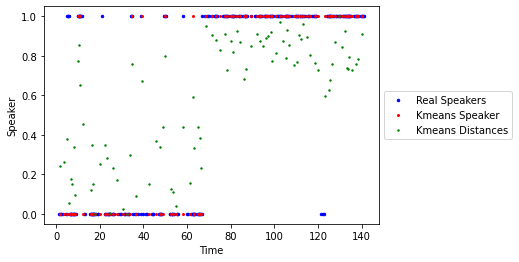

In [26]:
# Group of (minimum) minWord words : [deb_word_1 : end_word_3]
minWord = 3
minTime = 0.2

wordVectors3 = []
saveTimes3 = []
saveWords3 = []

bufferWords = []
for word in wordResult[:]:

    if not(bufferWords):
        startTime = word['start']
    stopTime = word['end']
    bufferWords.append(word['word'])

    wf.rewind()
    startFrame = int(np.floor(startTime * frameRate))
    try: wf.setpos(startFrame)
    except:
        print("Error for start time = ", str(startTime), " for total time = ", str(framesize*frameRate))
        break

    bufferFrames, totalTime  = fonc1(startTime, stopTime)

    if totalTime > minTime and len(bufferWords) >= minWord:
        try:
            rec = KaldiRecognizer(model, spk_model, frameRate)
            for buffer in bufferFrames:
                rec.AcceptWaveform(buffer)

            res = json.loads(rec.FinalResult())
            wordVectors3.append(res['spk'])
            saveWords3.append(bufferWords)
            saveTimes3.append((startTime+stopTime)/2)
            bufferWords = []
        except:
            print(bufferWords, totalTime, rec)
            break

# Plot
plotRes(wordVectors3, saveTimes3)

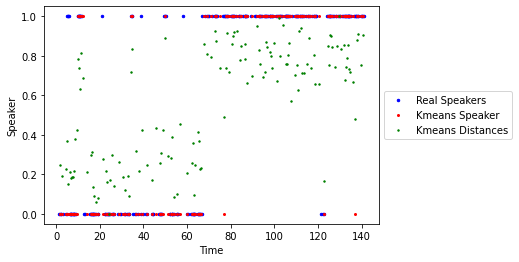

In [30]:
# Group of (minimum) minWord words : [deb_word_1:end_word_1+blank,..., deb_word_3:end_word_3+blank]
minWord = 2
minTime = 0.2

wordVectors6 = []
saveTimes6 = []
saveWords6 = []

bufferWords = []
for word in wordResult[1:]:

    if not(bufferWords):
        startTime = word['start']
    stopTime = word['end']
    bufferWords.append(word)

    bufferFrames, totalTime  = fonc2(bufferWords)

    if totalTime > minTime and len(bufferWords) >= minWord:

        rec = KaldiRecognizer(model, spk_model, frameRate)
        for buffer in bufferFrames:
            rec.AcceptWaveform(buffer)

        res = json.loads(rec.FinalResult())
        wordVectors6.append(res['spk'])
        saveWords6.append(bufferWords)
        saveTimes6.append((startTime+stopTime)/2)
        bufferWords = []

# Plot
plotRes(wordVectors6, saveTimes6)


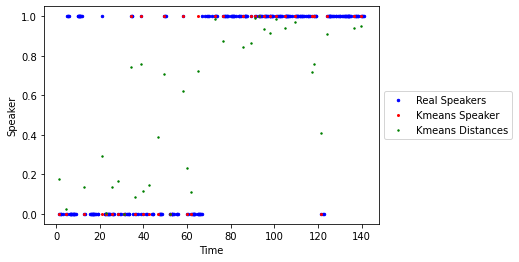

In [28]:
# Group of words chosen by Vosk ('complete utterance')
wordVectors5 = []
saveTimes5 = []
saveWords5 = []

wf.rewind()
rec = KaldiRecognizer(model, spk_model, frameRate)

while 1:
    data = wf.readframes(frameRate//rateBuf)
    if len(data) == 0:
        break
    if rec.AcceptWaveform(data):
        res = json.loads(rec.Result())
        wordVectors5.append(res['spk'])
        saveWords5.append([word['word'] for word in res['result']]) 
        saveTimes5.append((res['result'][0]['start']+res['result'][0]['end'])/2)

res = json.loads(rec.FinalResult())
if res['text'] != "":
    wordVectors5.append(res['spk'])
    saveWords5.append([word['word'] for word in res['result']]) 
    saveTimes5.append((res['result'][0]['start']+res['result'][0]['end'])/2)

# Plot
plotRes(wordVectors5, saveTimes5)